# Lab 4: Basic text preprocessing and topic modeling

The goal of this assignment is to get familiar with textual data analysis.


**Submission: submit via onq.** 


#pip install

In [1]:
# # install kaggle package

# # %%capture to hide a single code cell's output in Google Colab?
# %%capture
# !pip install kaggle

# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# # # download the data from kaggle
# !kaggle datasets download ahmedsalamas/stackoverflow

# # unzip the data 
# ! unzip stackoverflow

In [2]:
%%capture
!pip install pyLDAvis

#Import Libraries

In [3]:
# Import needed libraries. E.g., pandas, sklearn, nltk, etc. 
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import lxml
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet

from sklearn.decomposition import PCA
from matplotlib import pyplot

import gensim
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models import KeyedVectors
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


###download packages

In [4]:
# nltk packages
%%capture
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

#Task 1: The given dataset is a table containing questions about R on StackOverflow site. Your first task is to perform standard text prepossessing steps introduced in lectures for future tasks. You can perform analysis on title or body of the questions.

## Data Reading

In [5]:
# load the data.
df = pd.read_csv('/content/Questions.csv')

##Data Exploration

In [6]:
#diplay the first 5 rows
df.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,77434,14008.0,2008-09-16T21:40:29Z,171,How to access the last value in a vector?,<p>Suppose I have a vector that is nested in a...
1,79709,NaN,2008-09-17T03:39:16Z,3,Worse sin: side effects or passing massive obj...,<p>I have a function inside a loop inside a fu...
2,95007,15842.0,2008-09-18T17:59:19Z,56,Explain the quantile() function in R,<p>I've been mystified by the R quantile funct...
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,<p>How can I test for the <code>EOF</code> fla...
4,255697,1941213.0,2008-11-01T15:48:30Z,4,Is there an R package for learning a Dirichlet...,<p>I'm looking for a an <code>R</code> package...


In [7]:
#data shape
df.shape

(189930, 6)

In [8]:
#data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189930 entries, 0 to 189929
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            189930 non-null  int64  
 1   OwnerUserId   188729 non-null  float64
 2   CreationDate  189930 non-null  object 
 3   Score         189930 non-null  int64  
 4   Title         189930 non-null  object 
 5   Body          189930 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 8.7+ MB


In [9]:
#description of the all data
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,189930.0,NaN,NaN,NaN,30481062.300663,11257817.142532,77434.0,22571590.75,32159091.5,40093542.0,46395956.0
OwnerUserId,188729.0,NaN,NaN,NaN,3604743.082891,2256186.993384,277.0,1687633.0,3376134.0,5281720.0,8666903.0
CreationDate,189930,189801,2017-04-13T10:05:24Z,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Score,189930.0,NaN,NaN,NaN,1.930032,9.405712,-18.0,0.0,1.0,2.0,1973.0
Title,189930,189875,Scatter plot in R,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Body,189930,189911,<p>I working on survival analysis and each tim...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Checking for nulls
df.isnull().sum()

Id                 0
OwnerUserId     1201
CreationDate       0
Score              0
Title              0
Body               0
dtype: int64

> As we can see, only one column has null values, but that's not important because we only focus on `Title` or `Body` column

In [11]:
#checking for duplication
df.duplicated(subset=None).sum()

0

> As we can see, we don't have any duplicates and that's a good thing

> As we can see, from all the previous data exploration steps, we can find that the data quality is good so far

## Data Preprocessing

>* Remove HTML tags
>* Convert to lower case
>* Remove punctuation
>* Remove stop words
>* Remove special character


> ***In this Task I will work only on `Title` column***

In [12]:
#This method determines the part of speech type
def get_wordnet_pos(word):
  """Map POS tag to first character lemmatize() accepts"""
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}

  return tag_dict.get(tag, wordnet.NOUN)

In [13]:
#Text cleaning
token = ToktokTokenizer()
stemmer = WordNetLemmatizer()
# stemmer = SnowballStemmer(language='english')
stop_words = stopwords.words('english')
def preprocess_text(text):
  #Convert to lower case
  text = text.lower()
  # remove links
  text = re.sub(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', " ", text)
  #remove any html tags (< /br> often found)
  text = re.sub(r"<[^>]+>", " ", text)
  #Remove punctuation
  text = re.sub(r'!"$%&\'()*,./:;<=>?@[\\]^_`{|}~', " ", text)
  #convert all whitespaces (tabs etc.) to single wspace
  text = re.sub(r"\s+", " ", text)
  #remove special chars and numbers
  text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text)
  text = ''.join(i for i in text if not i.isdigit())
  text = re.sub(r"[^\w]", " ", text)
  # text = text.split()
  words = token.tokenize(text)
  #remove stop words
  no_stop_w = [stemmer.lemmatize(word, get_wordnet_pos(word)) for word in words if not word in set(stop_words)]
  text = ' '.join(map(str, no_stop_w))
  return text

In [14]:
%%time
#apply the preprocess_text Function on Tilte column and create a new column called clean_text column
df['clean_text'] = df['Title']
df['clean_text'] = df['clean_text'].apply(lambda x: str(x))
df['clean_text'] = df['clean_text'].apply(lambda x: preprocess_text(x))

CPU times: user 3min 23s, sys: 9.45 s, total: 3min 33s
Wall time: 3min 39s


In [15]:
df['clean_text']

0                                  access last value vector
1                bad sin side effect passing massive object
2                               explain quantile function r
3                                           test eof flag r
4                r package learn dirichlet prior count data
                                ...                        
189925              get command httr return anything minute
189926       r shiny discrete value supply continuous scale
189927    confidence interval quantile regression use bo...
189928               time lag analysis list impute datasets
189929    conditionally format text shiny give lookup he...
Name: clean_text, Length: 189930, dtype: object

In [16]:
df['clean_text'][10]

'operating time interval like'

In [17]:
df.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body,clean_text
0,77434,14008.0,2008-09-16T21:40:29Z,171,How to access the last value in a vector?,<p>Suppose I have a vector that is nested in a...,access last value vector
1,79709,NaN,2008-09-17T03:39:16Z,3,Worse sin: side effects or passing massive obj...,<p>I have a function inside a loop inside a fu...,bad sin side effect passing massive object
2,95007,15842.0,2008-09-18T17:59:19Z,56,Explain the quantile() function in R,<p>I've been mystified by the R quantile funct...,explain quantile function r
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,<p>How can I test for the <code>EOF</code> fla...,test eof flag r
4,255697,1941213.0,2008-11-01T15:48:30Z,4,Is there an R package for learning a Dirichlet...,<p>I'm looking for a an <code>R</code> package...,r package learn dirichlet prior count data


In [18]:
#checking for null values after update to see if there is any missing values happend
df.isnull().sum()

Id                 0
OwnerUserId     1201
CreationDate       0
Score              0
Title              0
Body               0
clean_text         0
dtype: int64

In [19]:
#checking for duplication
df.duplicated(subset=None).sum()

0

> As we can see, there is no any missing values related to `clean_text` column and there is no duplicates which is good

#Task 2: Using existing libraries, such as gensim https://radimrehurek.com/gensim/ to learn word embeddings from the prepossessed text from previous step. At the end of this step, you should save the learned word embeddings in a file.

> In this task, I will use Word2vec approach for word embedding.

> `Word2vec` : is an algorithm for learning a word embedding from a text corpus.

## Word Embeddings

In [20]:
#I will create a list from the clean_text column to give a results to a dictionary to make a text embeddings
corpusTxt = '\n'.join(df['clean_text'])
sentences = corpusTxt.split('\n')
sentences = [line.lower().split(' ') for line in sentences]

In [21]:
sentences[100]

['export', 'definition', 'r', 'object', 'plain', 'text', 'others', 'recreate']

In [22]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(sentences)

# Filter out words that occur less than 3 documents, or more than 80% of the documents.
model = dictionary.filter_extremes(no_below=3, no_above=0.8)

> Finally, we transform the documents to a vectorized form. We simply compute the frequency of each word, including the bigrams.

In [23]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in sentences]

In [24]:
corpus[100]

[(7, 1), (14, 1), (286, 1), (287, 1), (288, 1), (289, 1), (290, 1), (291, 1)]

In [25]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 8954
Number of documents: 189930


## Model Save

In [49]:
# min_count : Ignore words that appear less than this
# size : Dimensionality of word embeddings
# workers: parallel
# window=5: Context window for words during training

model_save = Word2Vec(sentences, size=50, window=5, min_count=2, workers=4)

In [52]:
# Store just the words + their trained embeddings.
%%capture
word_vectors = model_save.wv
word_vectors.save("word2vec.wordvectors")

In [53]:
%%capture
model_save.save("word2vec.wordvectors")

## virtualization 

In [45]:
# fit a 2d PCA model to the vectors
%%capture
X = model_save[model_save.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

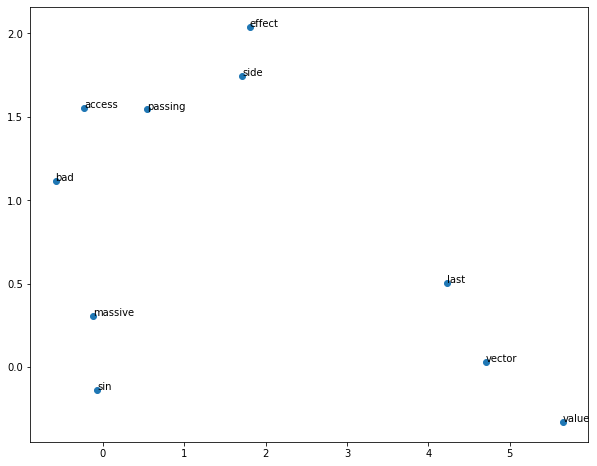

In [46]:
# create a scatter plot of the projection
plt.figure(figsize=(10,8))
pyplot.scatter(result[:10, 0], result[:10, 1])
words = list(model_save.wv.vocab)
words = words[:10]
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

#Task 3: Perform topic analysis on the prepossessed textual data. Briefly specify how you pick the number of topics. Present your findings (the final set of topics you extracted, the popularity of each topic). 

> to pick the number of topics, I will use two approaches
* `log_perplexity` : ( like elbow method)
* `coherence` : i will select the number which has high coherence score or around that

## Select Topic Number

In [28]:
# TODO code for task 3, hint, popularity of each topic is the ratio of documents discussing one topic, you need to read the topic assignment for each document and then calculate this value.
%%time
%%capture
# Set training parameters.
# I use passes = 2 because it's take long time (around 4 hours) when i use passes = 10 or more than 10
passes = 2
iterations = 500

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token
distortions = []
coherence_vals = []
for i in range(2, 20):
  model = LdaModel(
      corpus=corpus,
      id2word=id2word,
      iterations=iterations,
      num_topics=i,
      passes=passes,
  )
  distortions.append(model.log_perplexity(corpus))
  coherencemodel = CoherenceModel(model=model, texts=sentences, dictionary=dictionary, coherence='c_v')
  coherence_vals.append(coherencemodel.get_coherence())

CPU times: user 34min 52s, sys: 1min 2s, total: 35min 54s
Wall time: 34min 52s


> **perplexity distribution**

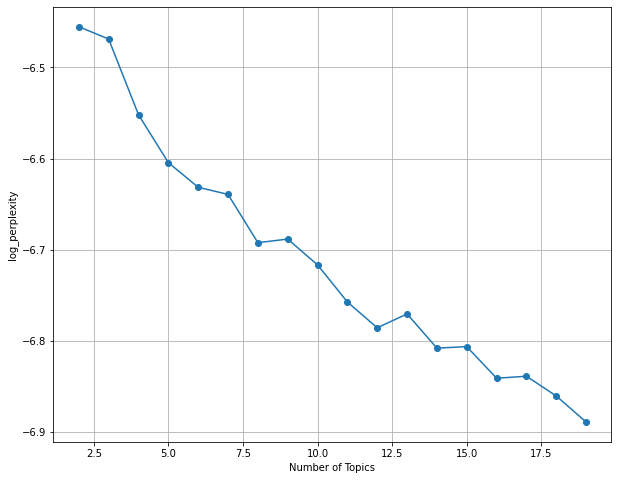

In [29]:
# plot
plt.figure(figsize=(10,8))
plt.plot(range(2, 20), distortions, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('log_perplexity')
plt.grid()
plt.show()

> **coherence distribution**

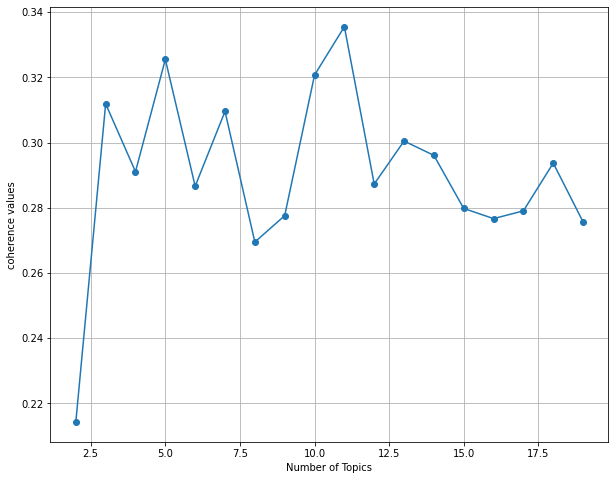

In [30]:
# plot
plt.figure(figsize=(10,8))
plt.plot(range(2, 20), coherence_vals, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('coherence values')
plt.grid()
plt.show()

> As we can see from the previous results we we can choose number of topic from this set `[10, 11, 12]` and see which number is good

## Train the models

> ### 10 Topics

In [33]:
# TODO code for task 3, hint, popularity of each topic is the ratio of documents discussing one topic, you need to read the topic assignment for each document and then calculate this value.
%%time
%%capture
# Set training parameters.
num_topics = 10
passes = 2
iterations = 500

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary. 
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    # iterations=iterations,
    num_topics=num_topics,
    passes=passes,
)

CPU times: user 1min 11s, sys: 1.14 s, total: 1min 12s
Wall time: 1min 13s


In [34]:
# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.175034  0.148860       1        1  20.144871
3      0.194170 -0.181520       2        1  11.648214
7     -0.142882  0.077956       3        1  10.476612
5     -0.189055 -0.107905       4        1  10.419977
8      0.127838  0.172818       5        1   9.834650
9     -0.213603  0.030416       6        1   8.260458
0      0.130502  0.056270       7        1   8.109621
6     -0.172950  0.005382       8        1   7.748970
2      0.076445 -0.309089       9        1   6.934051
4      0.014501  0.106812      10        1   6.422576, topic_info=         Term          Freq         Total Category  logprob  loglift
19       data  26708.000000  26708.000000  Default  30.0000  30.0000
73     column  19981.000000  19981.000000  Default  29.0000  29.0000
12   function  14585.000000  14585.000000  Default  28.0000  28.0000
71       plot  12878.000000  12878.000000  Default  27.0000  27.0000
269    ggplot  10225.000000  10225.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
22    package   1146.405391   8881.946600  Topic10  -4.1511   0.6980
99        use   1298.406996  24715.832161  Topic10  -4.0266  -0.2010
17       test    549.963453   2221.902289  Topic10  -4.8856   1.3491
7      object    564.583889   4144.319906  Topic10  -4.8594   0.7519
321       two    524.546727   5276.129293  Topic10  -4.9330   0.4369

[484 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         3  0.998905  access
1306      5  0.998018  accord
530       5  0.998151  across
147       1  0.347628     add
147       2  0.548197     add
...     ...       ...     ...
441       4  0.999173     xml
1320      7  0.998487      xt
804       9  0.999441    year
1543      1  0.260532    zero
1543      7  0.738770    zero

[584 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 8, 6, 9, 10, 1, 7, 3, 5])

> As we can see from the LDA virtualization, These results have a lot of overlap

> ### 11 Topics

In [35]:
# TODO code for task 3, hint, popularity of each topic is the ratio of documents discussing one topic, you need to read the topic assignment for each document and then calculate this value.
%%time
%%capture
# Set training parameters.
num_topics = 11
passes = 2
iterations = 500

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary. 
id2word = dictionary.id2token

model_2 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    # iterations=iterations,
    num_topics=num_topics,
    passes=passes,
)

CPU times: user 1min 2s, sys: 1.3 s, total: 1min 3s
Wall time: 1min 2s


In [36]:
# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model_2, corpus, dictionary)
lda_viz

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.234779  0.097884       1        1  13.549210
6      0.155337  0.099109       2        1  10.892923
1     -0.038745  0.007765       3        1   9.923720
8      0.100309 -0.251832       4        1   9.907727
4      0.070085  0.169976       5        1   9.355457
9      0.038703  0.030395       6        1   8.427709
0     -0.223807  0.013730       7        1   8.321631
7     -0.268733  0.078057       8        1   8.144208
5     -0.054183  0.118963       9        1   7.455597
10    -0.099203 -0.193339      10        1   7.117234
2      0.085458 -0.170708      11        1   6.904584, topic_info=         Term          Freq         Total Category  logprob  loglift
19       data  28592.000000  28592.000000  Default  30.0000  30.0000
12   function  14585.000000  14585.000000  Default  29.0000  29.0000
73     column  20398.000000  20398.000000  Default  28.0000  28.0000
71       plot  13042.000000  13042.000000  Default  27.0000  27.0000
2       value  16751.000000  16751.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
2       value   2156.757560  16751.840750  Topic11  -3.5915   0.6231
714     order    889.985415   2069.486745  Topic11  -4.4767   1.8291
204    number    662.825900   4809.632076  Topic11  -4.7713   0.6911
99        use    683.341687  24666.909054  Topic11  -4.7409  -0.9132
713       bar    594.063262   2208.895443  Topic11  -4.8809   1.3597

[502 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         5  0.293424  access
0         6  0.705384  access
1306      3  0.998691  accord
530       7  0.999350  across
147       1  0.335330     add
...     ...       ...     ...
1115     11  0.998383   wrong
59        4  0.999640       x
441       2  0.998712     xml
1320      7  0.998530      xt
804       5  0.999136    year

[607 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 2, 9, 5, 10, 1, 8, 6, 11, 3])

> As we can see from the LDA virtualization, These results have little overlap with respect to the previous results, but the overlap it's not a huge overlap which is so good

> ### 12 Topics

In [37]:
# TODO code for task 3, hint, popularity of each topic is the ratio of documents discussing one topic, you need to read the topic assignment for each document and then calculate this value.
%%time
%%capture
# Set training parameters.
num_topics = 12
passes = 2
iterations = 500

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary. 
id2word = dictionary.id2token

model_3 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    # iterations=iterations,
    num_topics=num_topics,
    passes=passes,
)

CPU times: user 1min 3s, sys: 1.43 s, total: 1min 4s
Wall time: 1min 5s


In [38]:
# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model_3, corpus, dictionary)
lda_viz

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.242535 -0.037313       1        1  13.735194
1     -0.015340  0.071214       2        1  10.236604
2      0.095746 -0.245859       3        1   9.166183
8     -0.217356 -0.116273       4        1   9.142398
4      0.156321  0.199363       5        1   8.305640
3      0.138772  0.139209       6        1   8.163731
7     -0.111806  0.132836       7        1   7.573122
9     -0.017816 -0.156749       8        1   7.510082
6      0.158105 -0.180801       9        1   7.309315
0     -0.061559  0.098619      10        1   7.007847
5     -0.098462  0.108571      11        1   5.926497
10     0.215929 -0.012816      12        1   5.923389, topic_info=          Term          Freq         Total Category  logprob  loglift
73      column  20097.000000  20097.000000  Default  30.0000  30.0000
19        data  27001.000000  27001.000000  Default  29.0000  29.0000
12    function  14626.000000  14626.000000  Default  28.0000  28.0000
269     ggplot  10126.000000  10126.000000  Default  27.0000  27.0000
5041     shiny   8855.000000   8855.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
14           r   3721.843739  84285.613877  Topic12  -2.8926  -0.2937
618       show    720.583131   1797.018524  Topic12  -4.5345   1.9124
99         use   1583.167274  24705.379171  Topic12  -3.7474   0.0787
556    cluster    454.712896   1300.691494  Topic12  -4.9949   1.7753
166        get    471.787898   5286.012241  Topic12  -4.9581   0.4100

[550 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0        11  0.998978  access
1306     10  0.998315  accord
530       1  0.998823  across
147       3  0.593185     add
147       4  0.132173     add
...     ...       ...     ...
441       6  0.999221     xml
1320      8  0.998098      xt
804      11  0.999419    year
1543      1  0.013910    zero
1543      8  0.985317    zero

[664 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 2, 3, 9, 5, 4, 8, 10, 7, 1, 6, 11])

> As we can see from the LDA virtualization, These results have little overlap with respect to the previous results

> so we will choose `model_2` with `11` topic to make a Topic Modeling

#conclusion and my findings

> From all of this I learned a lot of things like 
* I have learned new things in text preprocessing like in cleaning i used new approaches I didn't use them before like WordNetLemmatizer with another method to improve the performance of WordNetLemmatizer
* I have learned how to deal with `Word2Vec` or `doc2bow`
* and the important thing I have learned is how to deal with `Topic Modeling` and how to select the best `number of topic` for the model and how to virtualize all topics in good way
* I have learned that when the number of Topics increases it is not necessary for an overlap as in my task when I used `K = 10` I had a lot of overlap but when I used `K = 11` the overlap decreased because of this is `K` with `the highest coherence score`

> * I learned to be patient when I run codes like this 😀😀😀

#Refrence

[Ref.](https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)
[Ref.](https://stackoverflow.com/questions/35861482/nltk-lookup-error)
[Ref.](https://radimrehurek.com/gensim/models/word2vec.html)
[Ref.](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)